[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aprendizaje-automatico-dc-uba-ar/material/blob/main/notebooks/notebook_08_descenso_gradiente-published.ipynb)

# Descenso por gradiente

Vamos a explorar el método de descenso por gradiente para el cómputo de una regresión lineal.


In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from typing import Callable, Dict, Optional, Any

#### Datos para trabajar

Tenemos los siguientes datos generados al azar para ser ajustados por una regresión.

In [2]:
bias = 500
X, y, coef = make_regression(n_samples=5000,
                             n_features=3,
                             bias= bias,
                             noise=1, random_state=42, coef=True)

print(f"Generamos una matriz de {X.shape[0]} de observaciones de {X.shape[1]} atributos\n" +
      f"Target en el rango {(round(min(y),2), round(max(y),2))}\n" +
      f"los coeficientes con los que fueron generados son: {coef}")

print(f"Y = {bias} + {' + '.join([str(round(c,2)) + ' * X' + str(idx+1) for idx,c in enumerate(coef)])} + ε")

Generamos una matriz de 5000 de observaciones de 3 atributos
Target en el rango (np.float64(113.11), np.float64(865.44))
los coeficientes con los que fueron generados son: [38.95952484  1.51074456 89.82730651]
Y = 500 + 38.96 * X1 + 1.51 * X2 + 89.83 * X3 + ε


Los datos se ven así:

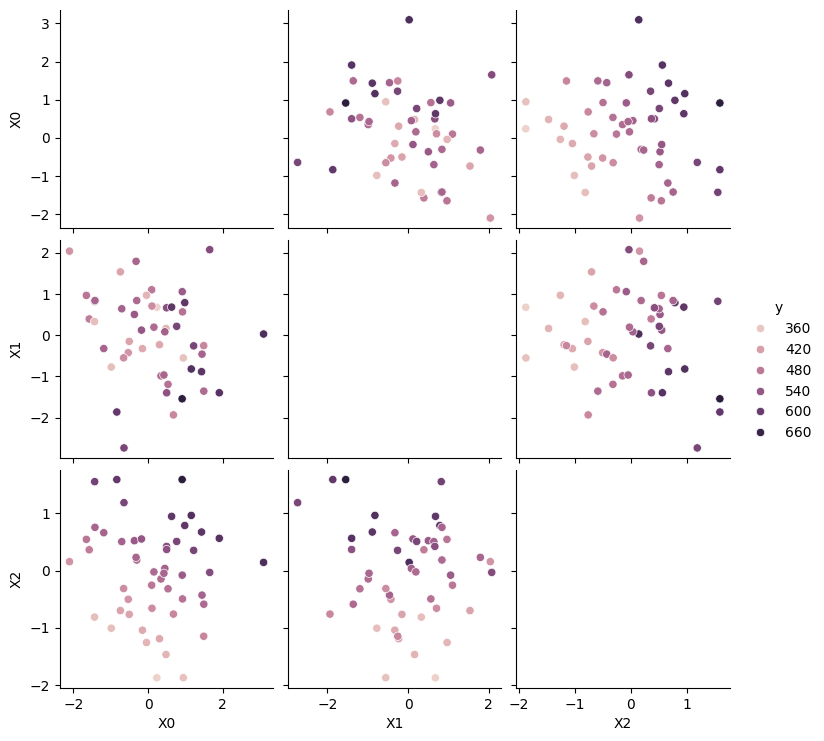

In [3]:
df = pd.DataFrame(X, columns=[f"X{i}" for i in range(X.shape[1])])
df["y"] = y
sns.pairplot(df.sample(50), hue="y")

En este notebook vamos a ver el resultado calculado de diversas formas, por lo que vamos a guardar para cada resultado los w y un valor de error.

In [4]:
# Usamos esta métrica, pero podemos reemplazarla por otra

def error_prediccion(X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
    # agrego columna para el intercept
    col_ones = np.ones((X.shape[0], 1))
    X_ext = np.hstack((col_ones, X))

    predicciones = np.dot(X_ext, w)

    return mean_squared_error(predicciones, y)

Los resultados los almacenaremos en un `DataFrame`.

In [5]:
# Guardo los datos para comparaciones posteriores
resultados = pd.DataFrame(columns=["metodo", "w0", "w1", "w2", "w3", "error_prediccion"])

err = error_prediccion(X, y, np.array([bias] + list(coef)))
resultados.loc[len(resultados)] = ["simulacion", bias] + list(coef) + [err]
resultados

,metodo,w0,w1,w2,w3,error_prediccion
0,simulacion,500,38.959525,1.510745,89.827307,1.001549


## Descenso por gradiente

Veamos ahora la función general

In [6]:
def descenso_gradiente(g, dg, z_init, alpha, num_iterations, tol, verbose=False):
    """
    Descenso de gradiente para minimizar g.
    Args:
        g: La función a optimizar.
        dg: El gradiente de la función.
        z_init: Valor inicial.
        alpha: El 'learning rate'.
        num_iterations: Máx iteraciones.
        tol: Tolerancia para la convergencia.
    """
    z = z_init
    for _ in range(num_iterations):
        gradient = dg(z) # gradient vale por ej <0.5, -0.2, -3, 0>
        z_new = z - (alpha * gradient)
        if abs(g(z_new) - g(z)) < tol:
            break
        z = z_new
    return z


Con esto es todo lo que necesitamos de descenso por gradiente.

## Regresión lineal

Podemos generarnos una clase que calcula la regresión lineal utilizando el método de  descenso por gradiente y nos devuelva los pesos correspondientes a los w de la regresión.



In [22]:
from sklearn import preprocessing
from functools import partial

class RegresionLinealDG():

    def __init__(self,
                 func_costo: Callable[..., float],
                 func_costo_grad: Callable[..., np.ndarray],
                 descenso_gradiente_hyperparams: Optional[Dict[str, Any]] = None):
        self.func_costo = func_costo
        self.func_costo_grad = func_costo_grad
        self.descenso_gradiente_hyperparams = descenso_gradiente_hyperparams
        self.collect_info = False

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        # agrego columna para el intercept
        col_ones = np.ones((X.shape[0], 1))
        X_train_ext = np.hstack((col_ones, X))

        cost_X_y = partial(self.func_costo, X=X_train_ext, y=y)
        grad_cost_X_y = partial(self.func_costo_grad, X=X_train_ext, y=y)

        w_shape = X_train_ext.shape[1]
        self.w = descenso_gradiente(cost_X_y, grad_cost_X_y,
                        z_init=np.zeros(w_shape),
                        **self.descenso_gradiente_hyperparams)


Con la clase `RegresionLinealDG` ya debemos definir en la creación la función de costo y el gradiente que se utilizan en el método (descenso por grandiente).

Empecemos usando MSE:

$MSE_{X,y} = \frac{1}{n} \sum_{i=1}^{n} (\hat{h}_{w_0,w_1,\ldots,w_p}(x^{(i)}) - y^{(i)})^2$

y su gradiente:

$\nabla_{\mathbf{w}} MSE_{X,y}(w) = \frac{2}{n} \sum_{i=1}^{n} (\hat{h}_{w_0,w_1,\ldots,w_p}(x^{(i)}) - y^{(i)}) * x^{(i)}$



In [8]:
def mse(w: np.ndarray, X: np.ndarray, y: np.ndarray) -> float:
    y_preds = X @ w
    return (1/len(y)) * np.sum((y_preds - y)**2)

def grad_mse(w: np.ndarray, X: np.ndarray, y: np.ndarray) -> np.ndarray:
    y_preds = X @ w
    return (2 / len(y)) * X.T @ (y_preds - y)

Podemos entonces crear nuestra regresión:

In [9]:
hyperparametros = {"alpha": 0.01, "num_iterations": 1000, "tol": 0.01}

reg = RegresionLinealDG(mse, grad_mse, hyperparametros)

Entrenarla:

In [10]:
reg.fit(X,y)

Y obtener los w

In [11]:
print("(DescensoG) w", reg.w.round(1))

err = error_prediccion(X, y, reg.w)
resultados.loc[len(resultados)] = [f"DescensoGradiente {hyperparametros['num_iterations']}"] + list(reg.w) + [err]

(DescensoG) w [499.5  38.9   1.5  89.7]


## Solución analítica

Analogamente, podemos computar el valor analitico de los _w_ con la fórmula:

$w = (X^T X)^{-1} X^T y$

In [12]:
from numpy.linalg import inv

def minimizacion_analitica(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    col_ones = np.ones((X.shape[0], 1))
    X_ext = np.hstack((col_ones, X))
    X_XT_inv = inv(X_ext.T @ X_ext)
    w_analitico = (X_XT_inv @ X_ext.T) @ y

    return w_analitico

Calculemos los w:

In [13]:
w_analitico = minimizacion_analitica(X, y)
print("(Analítico) w", w_analitico.round(1))

err = error_prediccion(X, y, w_analitico)
resultados.loc[len(resultados)] = [f"Analítico"] + list(w_analitico) + [err]
resultados

(Analítico) w [500.   39.    1.5  89.8]


,metodo,w0,w1,w2,w3,error_prediccion
0,simulacion,500.000000,38.959525,1.510745,89.827307,1.001549
1,DescensoGradiente 1000,499.531213,38.904996,1.488644,89.716010,1.252022
2,Analítico,500.019873,38.968244,1.475379,89.815231,0.999661


# Ejercicios

1. Realizar una grilla para los hyperparámetros de la regresión:

    `{"alpha": 0.01, "num_iterations": 1000, "tol": 0.01}`
    
    y reportar su comportamiento.

1. Implementar y experimentar el comportamiento con otra función de costo en lugar de MSE, elegir al menos una entre:
    - MSE_Ridge
    - MSE_Lasso
    - MSE_ElasticSearch
    
   Reportar los resultados en el DataFrame.
1. Modificar `RegresionLinealDG` para que realice mini-batch y verificar el funcionamiento comparando con el punto 1.


In [14]:
hiperparametros = {"alpha": 0.01, "num_iterations": 1000, "tol": 0.01}

reg2 = RegresionLinealDG(mse, grad_mse, hyperparametros)


In [15]:
reg2.fit(X,y)

In [16]:
print("(DescensoG) w", reg2.w.round(1))

err = error_prediccion(X, y, reg2.w)
resultados.loc[len(resultados)] = [f"DescensoGradiente {hyperparametros['num_iterations']}"] + list(reg2.w) + [err]

(DescensoG) w [499.5  38.9   1.5  89.7]


In [17]:
w_analitico = minimizacion_analitica(X, y)
print("(Analítico) w", w_analitico.round(1))

err = error_prediccion(X, y, w_analitico)
resultados.loc[len(resultados)] = [f"Analítico"] + list(w_analitico) + [err]
resultados

(Analítico) w [500.   39.    1.5  89.8]


,metodo,w0,w1,w2,w3,error_prediccion
0,simulacion,500.000000,38.959525,1.510745,89.827307,1.001549
1,DescensoGradiente 1000,499.531213,38.904996,1.488644,89.716010,1.252022
2,Analítico,500.019873,38.968244,1.475379,89.815231,0.999661
3,DescensoGradiente 1000,499.531213,38.904996,1.488644,89.716010,1.252022
4,Analítico,500.019873,38.968244,1.475379,89.815231,0.999661


In [18]:
def mse_ridge(w: np.ndarray, X: np.ndarray, y: np.ndarray, alpha: float) -> float:
    y_preds = X @ w
    mse = (1 / len(y)) * np.sum((y_preds - y) ** 2)
    l2_penalty = alpha * np.sum(w[1:] ** 2)  # no regulariza el término independiente w[0]
    return mse + l2_penalty

def grad_mse_ridge(w: np.ndarray, X: np.ndarray, y: np.ndarray, alpha: float) -> np.ndarray:
    y_preds = X @ w
    grad_mse = (2 / len(y)) * X.T @ (y_preds - y)
    l2_grad = 2 * alpha * np.r_[0, w[1:]]
    return grad_mse + l2_grad


def mse_lasso(w: np.ndarray, X: np.ndarray, y: np.ndarray, alpha: float) -> float:
    y_preds = X @ w
    mse = (1 / len(y)) * np.sum((y_preds - y) ** 2)
    l1_penalty = alpha * np.sum(np.abs(w[1:]))
    return mse + l1_penalty

def grad_mse_lasso(w: np.ndarray, X: np.ndarray, y: np.ndarray, alpha: float) -> np.ndarray:
    y_preds = X @ w
    grad_mse = (2 / len(y)) * X.T @ (y_preds - y)
    l1_grad = alpha * np.sign(w)
    l1_grad[0] = 0
    return grad_mse + l1_grad


def mse_elastic(w: np.ndarray, X: np.ndarray, y: np.ndarray, alpha: float, l1_ratio: float) -> float:
    y_preds = X @ w
    mse = (1 / len(y)) * np.sum((y_preds - y) ** 2)
    l1_penalty = l1_ratio * np.sum(np.abs(w[1:]))
    l2_penalty = (1 - l1_ratio) * np.sum(w[1:] ** 2)
    return mse + alpha * (l1_penalty + l2_penalty)

def grad_mse_elastic(w: np.ndarray, X: np.ndarray, y: np.ndarray, alpha: float, l1_ratio: float) -> np.ndarray:
    y_preds = X @ w
    grad_mse = (2 / len(y)) * X.T @ (y_preds - y)
    l1_grad = l1_ratio * np.sign(w)
    l2_grad = 2 * (1 - l1_ratio) * w
    elastic_grad = alpha * (l1_grad + l2_grad)
    elastic_grad[0] = 0
    return grad_mse + elastic_grad

In [24]:
from typing import Callable, Dict, Any, Optional
from sklearn.utils import shuffle

class RegresionLinealDG_B():
    def __init__(self,
                 func_costo: Callable[..., float],
                 func_costo_grad: Callable[..., np.ndarray],
                 descenso_gradiente_hyperparams: Optional[Dict[str, Any]] = None):
        self.func_costo = func_costo
        self.func_costo_grad = func_costo_grad
        self.descenso_gradiente_hyperparams = descenso_gradiente_hyperparams or {}
        self.collect_info = False

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        # Agrego columna para el término independiente
        col_ones = np.ones((X.shape[0], 1))
        X_ext = np.hstack((col_ones, X))
        n_samples, n_features = X_ext.shape

        # Hiperparámetros
        alpha = self.descenso_gradiente_hyperparams.get('alpha', 0.01)
        num_epochs = self.descenso_gradiente_hyperparams.get('num_epochs', 100)
        batch_size = self.descenso_gradiente_hyperparams.get('batch_size', 32)
        tol = self.descenso_gradiente_hyperparams.get('tol', 1e-6)

        # Inicialización de pesos
        self.w = np.zeros(n_features)

        for epoch in range(num_epochs):
            X_shuffled, y_shuffled = shuffle(X_ext, y)

            for i in range(0, n_samples, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                # Cálculo del gradiente en el mini-batch
                grad = self.func_costo_grad(self.w, X=X_batch, y=y_batch)

                # Actualización de pesos
                w_new = self.w - alpha * grad

                # Condición de parada (opcional)
                if np.linalg.norm(w_new - self.w) < tol:
                    self.w = w_new
                    return

                self.w = w_new


In [29]:
resultados2 = pd.DataFrame(columns=["metodo", "w0", "w1", "w2", "w3", "error_prediccion"])


In [30]:
hiperparametros = {"alpha": 0.01, "num_iterations": 1000, "tol": 0.01}

hiperparametros_B = {"alpha": 0.01, "num_iterations": 1000,"batch": 1, "tol": 0.01}

reg_1 = RegresionLinealDG(mse, grad_mse, hyperparametros)

reg_2 = RegresionLinealDG_B(mse, grad_mse, hyperparametros)

In [31]:
reg_1.fit(X,y)

reg_2.fit(X,y)

In [32]:
err = error_prediccion(X, y, reg_1.w)
resultados2.loc[len(resultados2)] = [f"sin batch"] + list(reg_1.w) + [err]

err = error_prediccion(X, y, reg_2.w)
resultados2.loc[len(resultados2)] = [f"con batch"] + list(reg_2.w) + [err]

In [33]:
resultados2

,metodo,w0,w1,w2,w3,error_prediccion
0,sin batch,499.531213,38.904996,1.488644,89.716010,1.252022
1,con batch,499.472580,38.921256,1.503841,89.706472,1.313624
